## Convolutional Neural Networks

This notebook is adapted from [ISLP](https://github.com/intro-stat-learning/ISLP_labs/blob/stable/Ch10-deeplearning-lab.ipynb).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.utils.data import TensorDataset, DataLoader
import torchvision

First, download CIFAR100 data.

In [2]:
batch_size = 128

(cifar_train,
 cifar_test) = [torchvision.datasets.CIFAR100(root="data",
                         train=train,
                         download=True)
             for train in [True, False]]

label_names = cifar_test.classes

transform = torchvision.transforms.ToTensor()
cifar_train_X = torch.stack([transform(x) for x in
                            cifar_train.data])
cifar_test_X = torch.stack([transform(x) for x in
                            cifar_test.data])
cifar_train = TensorDataset(cifar_train_X,
                            torch.tensor(cifar_train.targets))
cifar_test = TensorDataset(cifar_test_X,
                            torch.tensor(cifar_test.targets))

train_loader = DataLoader(cifar_train, batch_size=batch_size)
test_loader = DataLoader(cifar_test, batch_size=1000)

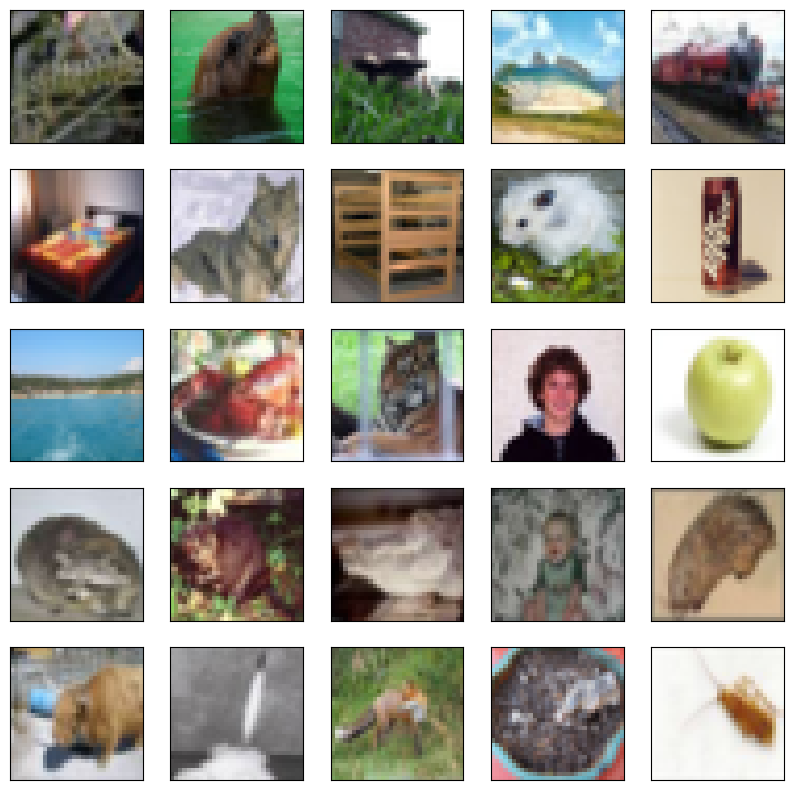

In [3]:
fig, axes = plt.subplots(5, 5, figsize=(10,10))
rng = np.random.default_rng(4)
indices = rng.choice(np.arange(len(cifar_train)), 25,
                     replace=False).reshape((5,5))
for i in range(5):
    for j in range(5):
        idx = indices[i,j]
        axes[i,j].imshow(np.transpose(cifar_train[idx][0],
                                      [1,2,0]),
                                      interpolation=None)
        axes[i,j].set_xticks([])
        axes[i,j].set_yticks([])


# note that torch requires image tensors to be [N, C, H, W]
# N: samples, C: channels, H: height, W: width

Let's set up our convolutional neural network for CIFAR100.

In [4]:

class BuildingBlock(nn.Module):

    def __init__(self,
                 in_channels,
                 out_channels):

        super(BuildingBlock, self).__init__()
        self.conv = nn.Conv2d(in_channels=in_channels,
                              out_channels=out_channels,
                              kernel_size=(3,3),
                              padding='same')
        self.activation = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=(2,2))

    def forward(self, x):
        return self.pool(self.activation(self.conv(x)))

# If the syntax *expression appears in the function call,
# expression must evaluate to an iterable. Elements from
# this iterable are treated as if they were additional
# positional arguments; if there are positional arguments
# x1, ..., xN, and expression evaluates to a sequence y1, ..., yM,
# this is equivalent to a call with M+N positional arguments x1, ..., xN, y1, ..., yM.

class CIFARModel(nn.Module):

    def __init__(self):
        super(CIFARModel, self).__init__()
        sizes = [(3,32),
                 (32,64),
                 (64,128),
                 (128,256)]
        self.conv = nn.Sequential(*[BuildingBlock(in_, out_)
                                    for in_, out_ in sizes])  # A single star * unpacks a sequence into positional arguments

        self.output = nn.Sequential(nn.Dropout(0.5),
                                    nn.Linear(2*2*256, 512),
                                    nn.ReLU(),
                                    nn.Linear(512, 100),
                                    nn.Softmax())
    def forward(self, x):
        val = self.conv(x)
        val = torch.flatten(val, start_dim=1)
        return self.output(val)

    def loss_fn(self, y, y_pred):
        log_pred = torch.log(y_pred + 1e-8)
        loss = -(log_pred * y).sum(1).mean()
        return loss


Let's instantiate the CIFAR100 model. Note: training the CIFAR100 model takes awhile (43 minutes)

In [5]:
model = CIFARModel()

In [ ]:
lr = 0.001
epochs = 50

optimizer = optim.Adam(model.parameters(), lr=lr)

In [5]:
# set model to training mode
model.train()

for epoch in range(epochs):
    epoch_loss = 0

    for x_batch, y_batch in train_loader:

        y_pred = model(x_batch)
        y_batch = F.one_hot(y_batch, num_classes=100)

        loss = model.loss_fn(y_batch, y_pred)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        epoch_loss += loss.item()

    if epoch % 10 == 0:
        print('epoch: ', epoch, 'loss:', f"{epoch_loss:.3}")


/Users/gm845/anaconda3/envs/msds534/lib/python3.11/site-packages/torch/nn/modules/container.py:217: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


epoch:  0 loss: 1.61e+03
epoch:  10 loss: 8.59e+02
epoch:  20 loss: 6.62e+02
epoch:  30 loss: 5.58e+02
epoch:  40 loss: 4.91e+02


We save the trained CIFAR100 model so we can access it later.

In [6]:
filename = 'cifar100-model'

In [6]:
torch.save(model.state_dict(), filename)

Load model:

In [7]:
model.load_state_dict(torch.load(filename))

<All keys matched successfully>

Let's calculate the accuracy of the model on a subset of the data.

In [8]:
model.eval()
x_batch, y_batch = next(iter(test_loader))
y_pred_array = model(x_batch)
y_pred = torch.argmax(y_pred_array, axis=1)
acc = (y_pred == y_batch).sum()
acc = acc / len(y_pred)

/Users/gm845/anaconda3/envs/msds534/lib/python3.13/site-packages/torch/nn/modules/module.py:1773: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


In [9]:
acc

tensor(0.4410)

A random classifier for 100 classes would get 1%. So not bad... but better models can get up to 90s.


Let's look at some examples the model got wrong:

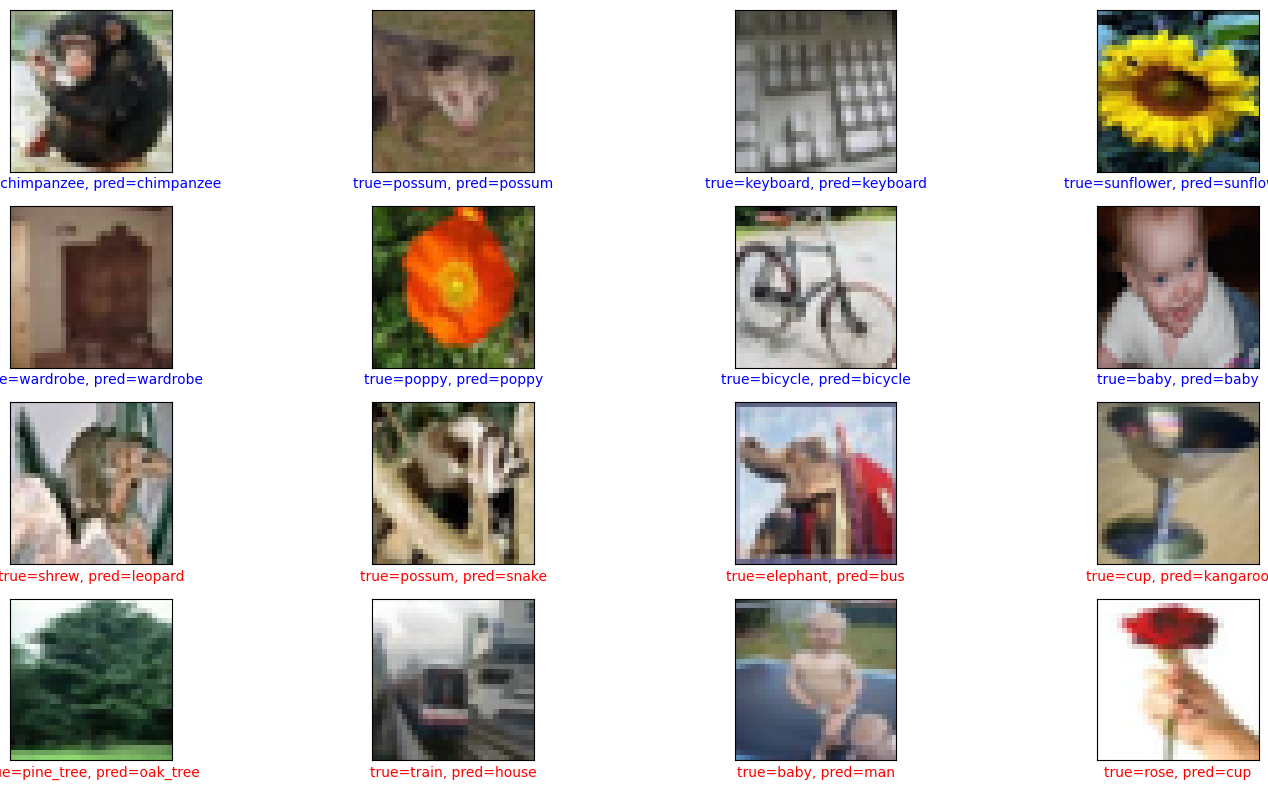

In [10]:
correct =  torch.where(y_pred == y_batch)[0]
errors = torch.where(y_pred != y_batch)[0]
inds1 = np.random.choice(correct.numpy(), size = 8)
inds2 = np.random.choice(errors.numpy(), size = 8)
inds = np.concatenate((inds1, inds2))

pred_array = y_pred_array.detach().numpy()

num_rows = 4
num_cols = 4
num_images = num_rows * num_cols
plt.figure(figsize=(2 * 2 * num_cols, 2 * num_rows))

for i in range(num_images):
    n = inds[i]
    plt.subplot(num_rows, num_cols, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    image, label = x_batch[n], y_batch[n]
    label = label_names[label]

    plt.imshow(np.transpose(image,
                        [1, 2, 0]),
           interpolation=None)
    plt.xlabel(label)
    predicted_label = label_names[y_pred[n]]
    if predicted_label == label:
        color = 'blue'
    else:
        color = 'red'
    plt.xlabel("true={}, pred={}".format(
        label,
        predicted_label),
        color=color)
    

plt.tight_layout() 


### ResNet

The `torchvision.models` package provides pre-trained models like ResNet-50 (a ResNet model with 50 layers). Here, we get the predictions from ResNet-50 for pictures of the professors' dogs. (Note: this uses code from [ISLP](https://github.com/intro-stat-learning/ISLP_labs/blob/stable/Ch10-deeplearning-lab.ipynb))

In [11]:
from torchvision.models import (resnet50, ResNet50_Weights)
from torchvision.transforms import (Resize,
                                    Normalize,
                                    CenterCrop,
                                    ToTensor)
from torchvision.io import read_image
from glob import glob
import json
import pandas as pd

In [12]:
resnet_model = resnet50(weights=ResNet50_Weights.DEFAULT)

In [13]:
# We need to normalize the images for use for ResNet-50

resize = Resize((232,232), antialias=True)
crop = CenterCrop(224)
normalize = Normalize([0.485,0.456,0.406],
                      [0.229,0.224,0.225])
imgfiles = sorted([f for f in glob('dogs/*')])
imgs = torch.stack([torch.div(crop(resize(read_image(f))), 255)
                    for f in imgfiles])
imgs_no_norm = imgs
imgs = normalize(imgs)
imgs.size()

torch.Size([3, 3, 224, 224])

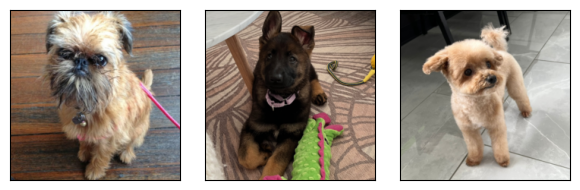

In [14]:
plt.figure(figsize=(2 * len(imgfiles), 2))

for i, imgfile in enumerate(imgfiles):
    plt.subplot(1, len(imgfiles), i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)

    plt.imshow(np.transpose(imgs_no_norm[i].numpy(),
                        [1, 2, 0]),
           interpolation=None)
    

plt.tight_layout() 

In [15]:
resnet_model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [16]:
img_preds = resnet_model(imgs)

In [17]:
img_preds.shape

torch.Size([3, 1000])

In [18]:
# apply softmax to the outputs of the ResNet
img_probs = np.exp(np.asarray(img_preds.detach()))
img_probs /= img_probs.sum(1)[:,None]

In [19]:
# get class labels -- this is available at https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json
labs = json.load(open('imagenet_class_index.json'))
class_labels = pd.DataFrame([(int(k), v[1]) for k, v in 
                           labs.items()],
                           columns=['idx', 'label'])
class_labels = class_labels.set_index('idx')
class_labels = class_labels.sort_index()

In [20]:
for i, imgfile in enumerate(imgfiles):
    img_df = class_labels.copy()
    img_df['prob'] = img_probs[i]
    img_df = img_df.sort_values(by='prob', ascending=False)[:3]
    print(f'Image: {imgfile}')
    print(img_df.reset_index().drop(columns=['idx']))

Image: dogs/bonnie.JPG
               label      prob
0  Brabancon_griffon  0.243078
1      affenpinscher  0.013340
2           Pekinese  0.004563
Image: dogs/maya.jpeg
                label      prob
0            malinois  0.221570
1     German_shepherd  0.102747
2  Norwegian_elkhound  0.007779
Image: dogs/milo.jpeg
              label      prob
0        toy_poodle  0.302865
1  miniature_poodle  0.133538
2          Shih-Tzu  0.024314
